In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Read CSV

In [3]:
df = pd.read_csv('D:/DIYA/SERVER/KNOW_dacon/KNOW_data/train/KNOW_2017.csv')
df = df.replace(' ', '0')
feature_name = list(df.columns.values)
df.head()

,idx,aq1_1,aq1_2,aq2_1,aq2_2,aq3_1,aq3_2,aq4_1,aq4_2,aq5_1,...,bq37,bq38,bq38_1,bq39_1,bq39_2,bq40,bq41_1,bq41_2,bq41_3,knowcode
0,0,3,3,3,3,3,3,4,4,3,...,52,2,실업,1,1,1,4000,0,2200,825101
1,1,4,5,4,5,3,4,3,4,3,...,38,4,건축공학,1,1,1,0,0,2400,140204
2,2,3,4,3,4,3,4,5,6,4,...,50,4,건축공학,1,1,1,4000,0,2400,140204
3,3,3,3,3,3,3,5,4,5,4,...,42,4,환경학과,1,1,1,7000,0,3500,140601
4,4,4,5,3,4,3,4,4,5,3,...,51,4,건축공학,1,1,1,4000,0,2500,140204


Preprocessing for EDA

In [20]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

str_list = [87, 88, 89, 92, 121, 139, 140, 141, 142, 143, 148] # string data index

np_data = np.array(df) # data frame to numpy

labels = np_data[:, -1:].reshape(-1)
str_data = np_data[:, str_list]
num_data = np.delete(np_data, str_list, 1)[:, 1:-1].astype(int)
num_data = num_data / np.max(num_data, axis = 0) # normalization

#encoding label
label_encoder = LabelEncoder()
label_encoder.fit(labels)          # number of class : 538
encoded_labels = label_encoder.transform(labels)

#one-hot encoding
one_hot_enc = OneHotEncoder()
one_hot_enc.fit(encoded_labels.reshape(-1, 1))
one_hot_labels = one_hot_enc.transform(encoded_labels.reshape(-1, 1)).toarray()

print("string data shape : \t{}".format(str_data.shape))
print("numeric data shape : \t{}".format(num_data.shape))
print("number of classes : \t{}".format(len(label_encoder.classes_)))
np_data.shape

string data shape : 	(9486, 11)
numeric data shape : 	(9486, 143)
number of classes : 	538


(9486, 156)

Label Distribution

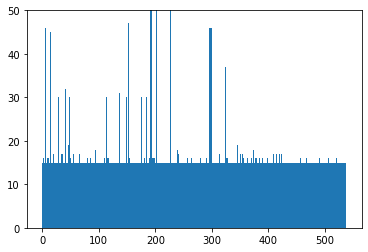

In [6]:
plt.hist(encoded_labels, bins=range(539))
plt.ylim(0, 50)
plt.show()

PCA and tSNE

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [8]:
 # PCA and tSNE with random 10 classes

random_classes = np.random.choice(537, 10, replace=False) # choice 10 classes randomly
# random_classes = label_encoder.transform(np.array([ ... ]))
#                               <-- user setting (lenght should be less than 10)
decoded_random_classes = label_encoder.inverse_transform(random_classes).astype(str)
filter = np.in1d(encoded_labels, random_classes)

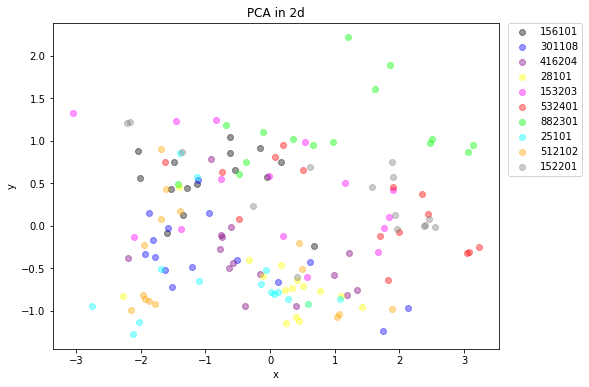

In [9]:
pca = PCA(n_components = 2)   # 2 dim
colors = ['black', 'blue', 'purple', 'yellow', 'magenta', 'red', 'lime', 'cyan', 'orange', 'gray']

pca_data = pca.fit_transform(num_data[filter, :])
pca_labels = encoded_labels[filter]

plt.figure(figsize=(8, 6))
for idx, class_ in enumerate(random_classes):
    x = pca_data[pca_labels == class_, 0]
    y = pca_data[pca_labels == class_, 1]
    plt.scatter(x, y, c = colors[idx], alpha = 0.4)

plt.xlabel('x')
plt.ylabel('y')
plt.title('PCA in 2d')
plt.legend(decoded_random_classes, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show()

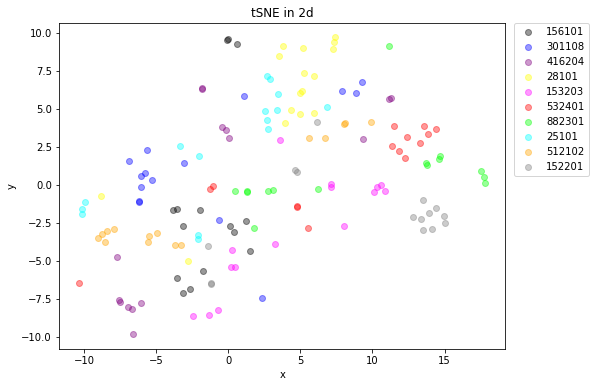

In [10]:
tsne = TSNE(n_components = 2)   # 2 dim
colors = ['black', 'blue', 'purple', 'yellow', 'magenta', 'red', 'lime', 'cyan', 'orange', 'gray']

tsne_data = tsne.fit_transform(num_data[filter, :])
tsne_labels = encoded_labels[filter]

plt.figure(figsize=(8, 6))
for idx, class_ in enumerate(random_classes):
    x = tsne_data[tsne_labels == class_, 0]
    y = tsne_data[tsne_labels == class_, 1]
    plt.scatter(x, y, c = colors[idx], alpha = 0.4)

plt.xlabel('x')
plt.ylabel('y')
plt.title('tSNE in 2d')
plt.legend(decoded_random_classes, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show()

Simple Network Training

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from keras.initializers import HeNormal

In [12]:
# train / validation data seperation (will be used to train dection tree)
train_features = num_data[:6000, :]
val_features = num_data[6000:, :]

train_label = one_hot_labels[:6000, :]
val_label = one_hot_labels[6000:, :]

In [13]:
model = Sequential([
    Dense(200, input_shape=(143,), activation='relu', kernel_initializer=HeNormal()),
    Dense(500, activation='relu', kernel_initializer=HeNormal()),
    BatchNormalization(),
    Dense(500, activation='relu', kernel_initializer=HeNormal()),
    BatchNormalization(),
    Dense(537, activation='softmax', kernel_initializer=HeNormal())
])
adam = optimizers.Adam(lr=0.003, decay=5e-5)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_features, train_label, validation_data=(val_features, val_label), epochs=50, batch_size=8)

/home/ahagyue/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
750/750 [==============================] - 2s 2ms/step - loss: 6.1892 - accuracy: 0.0403 - val_loss: 7.8572 - val_accuracy: 0.0380
Epoch 2/50
750/750 [==============================] - 1s 1ms/step - loss: 4.4950 - accuracy: 0.1148 - val_loss: 6.3893 - val_accuracy: 0.0896
Epoch 3/50
750/750 [==============================] - 1s 1ms/step - loss: 3.7921 - accuracy: 0.1955 - val_loss: 9.6721 - val_accuracy: 0.0612
Epoch 4/50
750/750 [==============================] - 1s 1ms/step - loss: 3.3728 - accuracy: 0.2527 - val_loss: 5.5311 - val_accuracy: 0.1179
Epoch 5/50
750/750 [==============================] - 1s 1ms/step - loss: 3.0245 - accuracy: 0.3053 - val_loss: 5.5500 - val_accuracy: 0.1379
Epoch 6/50
750/750 [==============================] - 1s 1ms/step - loss: 2.7496 - accuracy: 0.3548 - val_loss: 9.1066 - val_accuracy: 0.0673
Epoch 7/50
750/750 [==============================] - 1s 1ms/step - loss: 2.5240 - accuracy: 0.3915 - val_loss: 4.6029 - val_accuracy: 0.2091
Epoch 

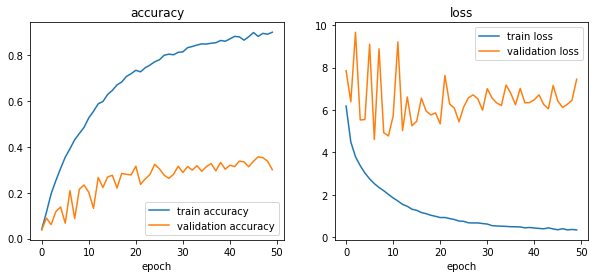

In [14]:
epoch = history.epoch
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,4))
plt.subplot(1,2, 1)
plt.plot(epoch, train_accuracy)
plt.plot(epoch, val_accuracy)
plt.title('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'])

plt.subplot(1, 2, 2)
plt.plot(epoch, train_loss)
plt.plot(epoch, val_loss)
plt.title('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])

Training Decision Tree and Random Forest

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

tree = DecisionTreeClassifier(max_depth=30, random_state=30)
tree.fit(train_features, train_label)

forest = RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=8)
forest.fit(train_features, train_label)

print("Decision Tree train dataset score : \t{}".format(tree.score(train_features, train_label)))
print("Decision Tree test dataset score : \t{}".format(tree.score(val_features, val_label)))
print("Random Forest train dataset score : \t{}".format(forest.score(train_features, train_label)))
print("Random Forest test dataset score : \t{}".format(forest.score(val_features, val_label)))

Decision Tree train dataset score : 	0.983
Decision Tree test dataset score : 	0.23550257731958762
Random Forest train dataset score : 	0.998
Random Forest test dataset score : 	0.029639175257731958


In [16]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree,
        out_file="tree.dot",
        feature_names=feature_name,
        class_names=label_encoder.classes_,
        rounded=True,
        filled=True
    )

import graphviz
with open("titanic.dot") as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='titanic_tree', directory='images/decision_trees', cleanup=True)
dot

ValueError: Length of feature_names, 156 does not match number of features, 142